In [1146]:
import time
import pandas as pd
import numpy as np
import random
import itertools
import re
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

# Кейс по нечеткому сравнению текстовых значений и анализу стоимости телефонов из двух разных интернет-магазинов
# Алтухов Николай



#### Данные были взяты с сайтов Regard и KNS. Файл с реализацией парсинга данных сайтов находится в файле "телефоны парсинг и обработка"

In [8]:
df_kns = pd.read_excel('kns телефоны.xlsx')
df_regard = pd.read_excel('regard телефоны.xlsx')

In [18]:
len(df_regard), len(df_kns)

(825, 659)

In [14]:
df_regard.sample()

,Ссылка,Название,Код производителя,Модель,RAM,ROM,Цвет,Цена
629,https://www.regard.ru/product/81420/smartfon-s...,Смартфон Samsung Galaxy S23 FE 8/256Gb Graphit...,SM-S711BZAGCAU,NaN,8 Гб,256 Гб,чёрный,58350


In [16]:
df_kns.sample()

,Название,Цена,Код производителя,Модель,RAM,ROM,Описание,Код производителя из описания,Цвет,RAM/ROM
502,Смартфон Samsung Galaxy A54 6/128GB Graphite S...,28139,SM-A546EZKAR06,Galaxy A54 6/128GB,6 Гб,128 Гб,"6.4"" 2340x1080, Android 13, 6 Гб, 128 Гб, осно...",SM-A546EZKAR06,графит,6/128GB


In [45]:
df_kns = df_kns.drop('Код производителя из описания', axis=1)


<p style="font-size:26px; color:#111; font-weight:400;">
    Из названия (реестра магазина Regard) вытащим данные по объему оперативной и встроенной памяти
</p>

<p style="font-size:26px; color:#111; font-weight:400;">
    Затем из столбца "цвет" буквы ё заменим на е, чтоб при сопоставлении значений различие в их правописании не играло роли
</p>

<p style="font-size:26px; color:#111; font-weight:400;">
    Также приведем значения в столбцах к нижнему регистру и удалим лишние пробелы
</p>

In [50]:
df_regard['RAM/ROM'] = df_regard['Название'].str.extract(r'(\d+/?\d*\s*(?:Tb|Gb))', flags=re.IGNORECASE,expand=False)

In [82]:
df_regard['Цвет'] = df_regard['Цвет'].str.lower().str.replace('ё','е')
df_kns['Цвет'] = df_kns['Цвет'].str.lower().str.replace('ё','е')

In [84]:
df_regard['RAM/ROM'] = df_regard['RAM/ROM'].str.lower()
df_kns['RAM/ROM'] = df_kns['RAM/ROM'].str.lower()

In [497]:
df_kns['Цвет'] = df_kns['Цвет'].str.replace(r'\(|\)', '', regex=True).str.strip()
df_regard['Цвет'] = df_regard['Цвет'].str.replace(r'\(|\)', '', regex=True).str.strip()

In [507]:
df_regard['Название'] = df_regard['Название'].str.lower().str.replace('ё','е')
df_kns['Название'] = df_kns['Название'].str.lower().str.replace('ё','е')
df_kns['Название'] = df_kns['Название'].str.replace(r'\(|\)', '', regex=True).str.strip()
df_regard['Название'] = df_regard['Название'].str.replace(r'\(|\)', '', regex=True).str.strip()

# Нечеткое сравнение названий

## Протестируем разные варианты методов нечеткого сравнения текстовых значений.
## Оценивать сопоставление будем по количеству совпадений в "коде производителя"

In [1013]:
def get_best_match(query, choices, scorer):
    match = process.extractOne(query, choices, scorer=scorer)
    if match:
        return match[0], match[1]
    else:
        return None, None

rapidfuzz_funcs = {
    "ratio":fuzz.ratio,            # Вычисляет расстояние Левенштейна, которое представляет собой минимальное количество односимвольных изменений (вставок, удалений или замен), необходимых для преобразования одной строки в другую
    "partial_ratio":fuzz.partial_ratio,    # вычисляет частичное расстояние Левенштейна (одна строка является подстрокой другой, или когда две строки имеют сильно различающиеся длины, но содержат общий подотрезок)
    "token_sort_ratio":fuzz.token_sort_ratio, # вычисляет расстояние Левенштейна после разделения строк на токены (слова или подстроки) и сортировки токенов в алфавитном порядке
    "token_set_ratio":fuzz.token_set_ratio,  # вычисляет расстояние Левенштейна между двумя множествами токенов, игнорирует порядок слов и дубликаты
    "QRatio":fuzz.QRatio,           # удаляет знаки препинания и лишние пробелы, приводит к ниж. регистру, вычисляет отношение схожести между двумя строками на основе количества совпадающих символов и учета частоты встречаемости символов в строках
    "WRatio":fuzz.WRatio,           # использует первые четыре метода, после чего взвешивает их результаты (т.е. учитывает различные аспекты строк)
    "partial_token_sort_ratio":fuzz.partial_token_sort_ratio, # вычисляет частичное расстояние Левенштейна между двумя строками, разбитыми на токены и отсортированными
    "partial_token_set_ratio":fuzz.partial_token_set_ratio # вычисляет частичное расстояние Левенштейна между двумя множествами токенов
}
for name, scorer in rapidfuzz_funcs.items():
    best_matches = df_regard['Название'].apply(lambda x: get_best_match(x, df_kns['Название'], scorer))

    # Разделяем результаты на два столбца
    df_regard['Лучшее сходство'] = best_matches.apply(lambda x: x[0])
    df_regard['Уровень схожести'] = best_matches.apply(lambda x: x[1])
    df_merged = df_regard.merge(df_kns, left_on='Лучшее сходство', right_on='Название', suffixes=[' kns',' regard'], how='left')
    
    print(f"Для метода {name} точных совпадений: {len(df_merged[df_merged['Код производителя regard'] == df_merged['Код производителя kns']])}")


Для метода ratio точных совпадений: 338
Для метода partial_ratio точных совпадений: 287
Для метода token_sort_ratio точных совпадений: 341
Для метода token_set_ratio точных совпадений: 350
Для метода QRatio точных совпадений: 338
Для метода WRatio точных совпадений: 338
Для метода partial_token_sort_ratio точных совпадений: 310
Для метода partial_token_set_ratio точных совпадений: 0


## Изначально я проводил тестирование, не приводя значения столбцов "Названия" к нижнему регистру и не удалял лишние пробелы и скобки
## После того как я обработал эти столбцы, значения результатов в некоторых методах, таких как token_sort_ratio, partial_token_sort_ratio и token_set_ratio подросли на 5-15%
## До обработки, впереди всех по результатам были методы ratio и QRatio. Теперь же явным лидером является token_set_ratio. Его и будем использовать

## При изучении наших реестров телефонов было выяснено, что у названий телефонов бывают дубликаты (при том, что у этих дубликатов различаются некоторые другие параметры).
## В этой связи учтем столбцы RAM/ROM, Цвет и Код производителя при сопоставлении значений. Коду производителя дадим больше веса, так как он является можно сказать идентификаторов смартфона

In [1079]:
def get_best_matches(query, choices, scorer, tolerance=3):
    matches = process.extract(query, choices, scorer=scorer)
    best_match_score = matches[0][1] if matches else 0
    filtered_matches = [match for match in matches if best_match_score - match[1] <= tolerance]
    return filtered_matches

def find_best_match_with_criteria(regard_row, kns_df, scorer, tolerance=4):
    matches = get_best_matches(regard_row['Название'], kns_df['Название'], scorer, tolerance)
    
    def match_criteria(match):
        kns_row = kns_df.loc[kns_df.index == match[2]].iloc[0]  # Используем индекс как ID
        criteria = [
            ('Код производителя', regard_row['Код производителя'], kns_row['Код производителя'], 2),  # Вес 2 для "Код производителя"
            ('Цвет', regard_row['Цвет'], kns_row['Цвет'], 1),  # Вес 1 для "Цвета"
            ('RAM/ROM', regard_row['RAM/ROM'], kns_row['RAM/ROM'], 1)  # Вес 1 для "RAM/ROM"
        ]
        
        match_count = sum(weight if r_val == k_val else 0 for col, r_val, k_val, weight in criteria)
        return match_count, match[2], match[0], match[1]
    
    sorted_matches = sorted([match_criteria(match) for match in matches], key=lambda x: (-x[0], -x[3]))
    
    best_match = sorted_matches[0] if sorted_matches else (0, None, None, 0)
    return best_match[1], best_match[2], best_match[3]

df_regard['Лучшее сходство'] = None
df_regard['Уровень схожести'] = None
df_regard['ID лучшего совпадения'] = None

for idx, row in df_regard.iterrows():
    best_id, best_match, best_score = find_best_match_with_criteria(row, df_kns, fuzz.token_set_ratio)
    df_regard.at[idx, 'Лучшее сходство'] = best_match
    df_regard.at[idx, 'Уровень схожести'] = best_score
    df_regard.at[idx, 'ID лучшего совпадения'] = best_id

df_merged = df_regard.merge(df_kns, left_on='Лучшее сходство', right_on='Название', suffixes=[' regard',' kns'], how='left')
len(df_merged[df_merged['Код производителя regard'] == df_merged['Код производителя kns']])

365

## Как видим, наши старания дали свои плоды, количество совпадений увеличилось
## Теперь оценим сколько всего кодов производителя совпадают среди двух наших датафреймов. Для этого просто сделаем merge по кодам производителя

In [1081]:
df_merged_test = df_regard.merge(df_kns, left_on='Код производителя', right_on='Код производителя', how='left')
df_merged_test_same_code = df_merged_test[df_merged_test['Описание'].notna()]
len(df_merged_test_same_code)

371

In [1082]:
df_merged_test_same_code.sample()

,Ссылка,Название_x,Код производителя,Модель_x,RAM_x,ROM_x,Цвет_x,Цена_x,Лучшее сходство,Уровень схожести,RAM/ROM_x,ID лучшего совпадения,Название_y,Цена_y,Модель_y,RAM_y,ROM_y,Описание,Цвет_y,RAM/ROM_y
782,https://www.regard.ru/product/80934/smartfon-a...,смартфон apple iphone 15 pro 512gb blue titani...,MTUL3J/A,Apple iPhone 15 Pro,8 Гб,512 Гб,синий,140090,смартфон apple iphone 15 pro 512gb blue mtul3j/a,100.0,512gb,541,смартфон apple iphone 15 pro 512gb blue mtul3j/a,147158.0,iPhone 15 Pro 512GB,NaN,512 Гб,"Apple A17 Pro, 6.1"" 2556x1179, iOS 17, 512 Гб,...",синий титан,512gb


_________
### Количество почти совпадает с тем, что получилось при нечетком сравнении

## Теперь посмотрим какие значения не сошлись по коду производителя при нечетком сравнении

In [1084]:
df_merged_test_same_code_and_rk = df_merged_test_same_code.merge(df_merged[df_merged['Код производителя regard'] == df_merged['Код производителя kns']], left_on='Код производителя', right_on='Код производителя regard', how='left')

### так как колонок слишком много, оставим только нужные

### Столбец "Название_x" содержит значения с сайта Regard, "Название_y" - с сайта KNS. Столбец "Лучшее сходство_x" содержит значения, которые были получены при нечетком сравнении. 
### "Код производителя" здесь одинаков у обоих сайтов

In [1087]:
required_columns = df_merged_test_same_code_and_rk.columns[df_merged_test_same_code_and_rk.columns.str.contains('Код произ|Назван|сходств|RAM/ROM|Цвет')]
df_merged_test_same_code_and_rk[df_merged_test_same_code_and_rk['Код производителя regard'].isna()][required_columns]

,Название_x,Код производителя,Цвет_x,Лучшее сходство_x,RAM/ROM_x,Название_y,Цвет_y,RAM/ROM_y,Название regard,Код производителя regard,Цвет regard,Лучшее сходство_y,RAM/ROM regard,Название kns,Код производителя kns,Цвет kns,RAM/ROM kns
7,смартфон xiaomi redmi 13c 4/128gb glacier white,MZB0FTQRU,белый,смартфон xiaomi redmi 13c 4/128gb glacier white,4/128gb,смартфон xiaomi redmi 13c 8/256gb glacier white,белый,8/256gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,смартфон huawei nova 10 se 8/128gb black 51097mye,51097MYE,черный,смартфон huawei nova y91 8/128gb black,8/128gb,смартфон huawei nova 10 se 8/256gb black,черный,8/256gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,смартфон huawei nova 10 se 8/128gb green 51097myd,51097MYD,зеленый,смартфон huawei nova 12i 8/128gb green,8/128gb,смартфон huawei nova 10 se 8/256gb green,зеленый,8/256gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,смартфон huawei nova 10 se 8/128gb silver 5109...,51097MYC,серебристый,смартфон huawei nova y91 8/128gb silver,8/128gb,смартфон huawei nova 10 se 8/256gb silver,серебристый,8/256gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,смартфон samsung galaxy a35 8/128gb light viol...,SM-A356ELVDSKZ,розовый,смартфон samsung galaxy a35 8/128gb light viol...,8/128gb,смартфон samsung galaxy a35 8/128gb awesome li...,лаванда,8/128gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,смартфон samsung galaxy a35 8/128gb light viol...,SM-A356ELVDCAU,розовый,смартфон samsung galaxy a35 8/128gb light viol...,8/128gb,смартфон samsung galaxy a35 8/128gb awesome li...,лаванда,8/128gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,смартфон samsung galaxy a55 8/128gb light blue...,SM-A556ELBASKZ,голубой,смартфон samsung galaxy a55 8/128gb light blue...,8/128gb,смартфон samsung galaxy a55 8/128gb awesome ic...,голубой,8/128gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Далее можно посмотреть код производителя подтянутого значения по нечеткому сравнению (столбцы "Код производителя regard" и "Код производителя kns"):

In [1089]:
required_columns2 = df_merged.columns[df_merged.columns.str.contains('Код произ|Назван|сходств|RAM/ROM|Цвет')]
names_of_unfound = df_merged_test_same_code_and_rk[df_merged_test_same_code_and_rk['Код производителя regard'].isna()][required_columns]['Название_x']
df_merged[df_merged['Название regard'].isin(names_of_unfound)][required_columns2]


,Название regard,Код производителя regard,Цвет regard,Лучшее сходство,RAM/ROM regard,Название kns,Код производителя kns,Цвет kns,RAM/ROM kns
167,смартфон xiaomi redmi 13c 4/128gb glacier white,MZB0FTQRU,белый,смартфон xiaomi redmi 13c 4/128gb glacier white,4/128gb,смартфон xiaomi redmi 13c 4/128gb glacier white,MZB0FJCRU,белый,4/128gb
408,смартфон huawei nova 10 se 8/128gb black 51097mye,51097MYE,черный,смартфон huawei nova y91 8/128gb black,8/128gb,смартфон huawei nova y91 8/128gb black,51097LTW,черный,8/128gb
409,смартфон huawei nova 10 se 8/128gb green 51097myd,51097MYD,зеленый,смартфон huawei nova 12i 8/128gb green,8/128gb,смартфон huawei nova 12i 8/128gb green,51097UDG,зеленый,8/128gb
410,смартфон huawei nova 10 se 8/128gb silver 5109...,51097MYC,серебристый,смартфон huawei nova y91 8/128gb silver,8/128gb,смартфон huawei nova y91 8/128gb silver,51097LTV,серебристый,8/128gb
483,смартфон samsung galaxy a35 8/128gb light viol...,SM-A356ELVDSKZ,розовый,смартфон samsung galaxy a35 8/128gb light viol...,8/128gb,смартфон samsung galaxy a35 8/128gb light viol...,SM-A356ELVPMEA,лаванда,8/128gb
505,смартфон samsung galaxy a35 8/128gb light viol...,SM-A356ELVDCAU,розовый,смартфон samsung galaxy a35 8/128gb light viol...,8/128gb,смартфон samsung galaxy a35 8/128gb light viol...,SM-A356ELVPMEA,лаванда,8/128gb
545,смартфон samsung galaxy a55 8/128gb light blue...,SM-A556ELBASKZ,голубой,смартфон samsung galaxy a55 8/128gb light blue...,8/128gb,смартфон samsung galaxy a55 8/128gb light blue...,SM-A556ELBACAU,голубой,8/128gb



<p style="font-size:26px; color:#111; font-weight:400;">
    Интересно, что нечеткое сравнение справилось лучше чем прямое сопоставление по коду производителя с самих сайтов, потому что если смотреть по значениям "Название_x" и "Название_y" для одинакового кода производителя, они отличаются и неверны: либо по цвету, либо по RAB/ROM. 
</p>


<p style="font-size:26px; color:#111; font-weight:400;">
    но у нас еще остались значения, которые мы не можем сравнить по коду производителя 
</p>

<p style="font-size:26px; color:#111; font-weight:400;">
    нужно определить ниже какого уровня схожести значения начинают значительно не совпадать, и удалить все значения ниже такого уровня 
</p>

In [1098]:
required_columns2 = df_merged.columns[df_merged.columns.str.contains('Код произ|Назван|сходств|RAM/ROM|Цвет|схож')]
df_merged[required_columns2][(df_merged['Уровень схожести']>85)&(df_merged['Уровень схожести']<=90)]

,Название regard,Код производителя regard,Цвет regard,Лучшее сходство,Уровень схожести,RAM/ROM regard,Название kns,Код производителя kns,Цвет kns,RAM/ROM kns
113,смартфон infinix smart 8 3/64gb black,10047427,черный,смартфон infinix smart 6 2/32gb black,89.189189,3/64gb,смартфон infinix smart 6 2/32gb black,10028448,черный,2/32gb
149,смартфон tecno spark 20c 4/128gb alpenglow gold,NaN,золотистый,смартфон tecno spark 8p 4/128gb cyan,87.5,4/128gb,смартфон tecno spark 8p 4/128gb cyan,TCN-KG7N.128.TAGO,голубой матовый/медный,4/128gb
150,смартфон tecno spark 20c 4/128gb black,NaN,черный,смартфон tecno spark 8p 4/128gb cyan,87.5,4/128gb,смартфон tecno spark 8p 4/128gb cyan,TCN-KG7N.128.TAGO,голубой матовый/медный,4/128gb
152,смартфон infinix smart 8 plus 4/128gb black,10047656,черный,смартфон infinix hot 40i 4/128gb black,88.235294,4/128gb,смартфон infinix hot 40i 4/128gb black,4894947012860,черный,4/128gb
157,смартфон xiaomi poco m5 4/64gb black,X42480/X42486/42504,черный,смартфон xiaomi poco c65 8/256gb black,89.189189,4/64gb,смартфон xiaomi poco c65 8/256gb black,MZB0FLURU,черный,8/256gb
163,смартфон blackview bv4800 3/64gb black,NaN,черный,смартфон blackview bv9200 8/256gb black,88.311688,3/64gb,смартфон blackview bv9200 8/256gb black,6931548310563,черный,8/256gb
175,смартфон umidigi g1 max 6/128gb black,C.G1MA-U-J-192-B-Z01,черный,смартфон umidigi bison 2 6/128gb hack black,89.552239,6/128gb,смартфон umidigi bison 2 6/128gb hack black,C.BI20-U-J-192-B-Z01,черный,6/128gb
191,смартфон blackview color 8 8/128gb black,NaN,черный,смартфон blackview bv5300 plus 8/128gb black,88.888889,8/128gb,смартфон blackview bv5300 plus 8/128gb black,6931548316442,черный,8/128gb
201,смартфон infinix hot 30i 8/128gb cyan,10041755,"зеленый, синий",смартфон infinix hot 30 8/128gb black,89.189189,8/128gb,смартфон infinix hot 30 8/128gb black,10040071,черный,8/128gb
209,смартфон vivo y18 6/128gb wave aqua,NaN,голубой,смартфон vivo y18 6/128gb brown,89.285714,6/128gb,смартфон vivo y18 6/128gb brown,5667047,коричневый,6/128gb


### Еще нужно помнить, что не все значения могли полностью подтянуться, потому что на этих сайтах продаются разные множества моделей
### И на сайте Regard телефонов представлено больше, чем на сайте KNS
### Например, на сайте KNS представлены не все цвета какой-то модели телефона, поэтому нормально, что для, например, зеленого Iphone 14 из Regard сопоставится черный Iphone 14 из KNS

<p style="font-size:26px; color:#111; font-weight:400;">
    Пороговое значение получилось равным 90. Ниже этого значения схожесть начинает значительно страдать, а выше - в абсолютном большинстве случаев верно сопоставляет значения
</p>

In [1102]:
df_merged = df_merged[(df_merged['Уровень схожести']>=90)]
len(df_merged)

588

In [1104]:
len(df_regard), len(df_kns)

(825, 659)

<p style="font-size:26px; color:#111; font-weight:400;">
    Максимум 659 пар значений могло сопоставиться (так как на сайте KNS всего 659 телефонов находится в продаже), у нас же получилось сопоставить 588 значений. Причина в том, что остальные телефоны просто находятся только на каком-то одном из сайтов
</p>


__________________
__________________

# Сравнение стоимости телефонов интернет магазинов Regard и KNS

In [1109]:
df_merged['Разница стоимости'] = df_merged['Цена regard'] - df_merged['Цена kns']

In [1111]:
'медиана',df_merged['Разница стоимости'].median()

('медиана', 844.5)

In [1113]:
'среднее значение', df_merged['Разница стоимости'].mean()

('среднее значение', -86.5561224489796)

In [1115]:
df_merged['Разница стоимости'].mean()

-86.5561224489796

In [1117]:
df_merged.describe()

,Цена regard,Цена kns,Разница стоимости
count,588.000000,588.000000,588.000000
mean,49229.421769,49315.977891,-86.556122
std,47442.390784,48495.798125,6107.720222
min,4030.000000,3926.000000,-56823.000000
25%,15807.500000,15357.750000,-149.750000
50%,28535.000000,27648.500000,844.500000
75%,72310.000000,70266.000000,1458.000000
max,212120.000000,214071.000000,25349.000000



<p style="font-size:26px; color:#111; font-weight:400;">
    из-за того, что некоторые телефоны все-таки плохо сопоставились, мы видим, что стандартное отклонение в стоимости достаточно высокое, а минимальные и максимальные разницы стоимости составляют 25 тыс. и 56 тыс. рублей. Неудачное сопоставление пары телефонов может давать сильную разницу в стоимости. Я изучил, где разница в стоимости у телефонов составляет более 5 тысяч. Видно, что в этих случаях есть относительно много неверных сопоставлений, поэтому для разниц в +-5 тысяч рублей я поставлю ограничение на уровень схожести более 95
</p>


In [1119]:
df_merged = df_merged.drop(df_merged[(df_merged['Разница стоимости']>5000)&(df_merged['Уровень схожести']<95)].index)
df_merged = df_merged.drop(df_merged[(df_merged['Разница стоимости']<-5000)&(df_merged['Уровень схожести']<95)].index)

In [1121]:
df_merged.describe()

,Цена regard,Цена kns,Разница стоимости
count,554.000000,554.000000,554.000000
mean,49405.306859,49374.158845,31.148014
std,47876.426871,48932.514998,4970.858549
min,4030.000000,3926.000000,-36629.000000
25%,15762.500000,15297.000000,2.500000
50%,28350.000000,27730.000000,850.000000
75%,72135.000000,70266.000000,1396.750000
max,212120.000000,214071.000000,22169.000000


### На всякий случай проверим минимальную разницу стоимости (которая составляет 36 тысяч), адекватно ли сработало нечеткое сравнение для этого случая

In [1128]:
df_merged[df_merged['Разница стоимости']==df_merged['Разница стоимости'].min()]

,Ссылка,Название regard,Код производителя regard,Модель regard,RAM regard,ROM regard,Цвет regard,Цена regard,Лучшее сходство,Уровень схожести,...,Название kns,Цена kns,Код производителя kns,Модель kns,RAM kns,ROM kns,Описание,Цвет kns,RAM/ROM kns,Разница стоимости
616,https://www.regard.ru/product/443091/smartfon-...,смартфон xiaomi 12 8/128gb grey,37065,Xiaomi 12,8 Гб,128 Гб,серый,53760,смартфон xiaomi 12 8/128gb grey,100.0,...,смартфон xiaomi 12 8/128gb grey,90389,12 8/128GB Grey,12 8/128GB,8 Гб,128 Гб,"Qualcomm Snapdragon 8 Gen 1 3.0 GHz, 6.28"" 240...",серый,8/128gb,-36629


### Как видим, нечеткое сравнение в данном случае сработало идеально

In [1123]:
'медиана',df_merged['Разница стоимости'].median()

('медиана', 850.0)

In [1125]:
'среднее значение', df_merged['Разница стоимости'].mean()

('среднее значение', 31.14801444043321)


<p style="font-size:26px; color:#111; font-weight:400;">
    Устойчивая к выбросам медиана не изменилась, среднее значение все так же находится около нуля. Я так же отдельно пробовал ставить ограничение для разниц в +-1 тысячу рублей на уровень схожести более 95, значения практически не поменялись. 
</p>


<p style="font-size:26px; color:#111; font-weight:400;">
    Стоит отметить, что наверняка цвет телефона влияет на стоимость. А у нас, из-за того, что количество телефонов на сайте KNS было меньше, для некоторых телефонов сайта Regard сопоставились телефоны KNS другого цвета.
</p>

Text(0.5, 0, 'Разница стоимости')

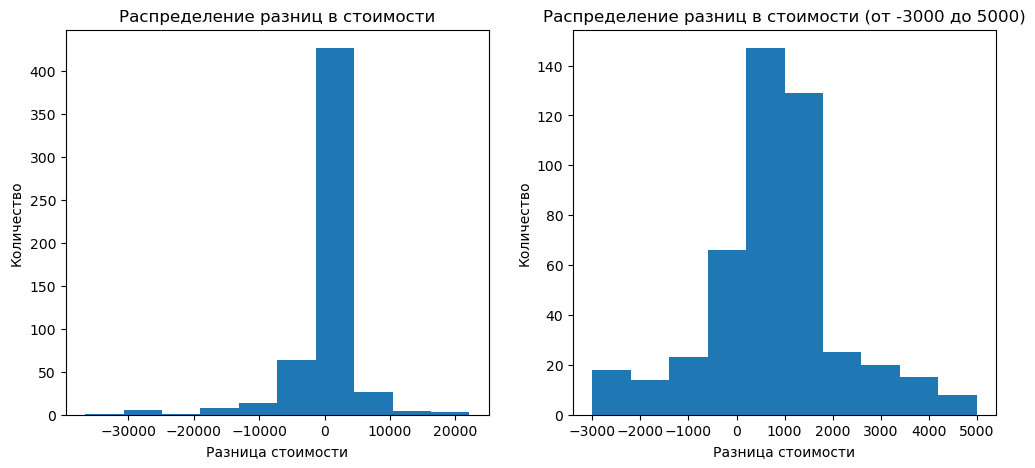

In [1190]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(df_merged['Разница стоимости'])
axs[0].set_title("Распределение разниц в стоимости")
axs[0].set_ylabel("Количество")
axs[0].set_xlabel("Разница стоимости")

axs[1].hist(df_merged['Разница стоимости'], range=[-3000, 5000], bins=10)
axs[1].set_title("Распределение разниц в стоимости (от -3000 до 5000)")
axs[1].set_ylabel("Количество")
axs[1].set_xlabel("Разница стоимости")

### На графиках видно, что разницы стоимости по большей части распределены около нуля. Но при приближении графика, видно что значения больше находятся справа от нуля. Что нам и показывает медиана.

### Таким образом можно заключить, что в большинстве случаев выгоднее покупать телефоны на сайте KNS

### В целом выполнение нечеткого сравнения и анализа считаю успешно выполненным